### Note: If you are using Google Colab, please uncomment this cell and run:

In [ ]:
# !git clone https://github.com/davemlz/foss4g24eu-esdc.git
# !pip install -r foss4g24eu-esdc/requirements.txt

# 2. Creating Earth System Data Cubes (ESDCs) from scratch
### Duration: 40 min
---

This notebook is divided as follows:

- Part 1. Spatiotemporal Asset Catalogs (STAC)
- Part 2. Google Earth Engine (GEE)
- Part 3. BONUS: Creating AI-focused ESDCs from STAC or GEE with `cubo`

## Part 1. Spatiotemporal Asset Catalogs (STAC)

SpatioTemporal Asset Catalog (STAC) is a specification for indexing geospatial data through a common standard (see [https://stacspec.org/en](https://stacspec.org/en)).

<img src="https://stacindex.org/img/logo.32c921b9.png" alt="stac" width="700"/>

There are three important objects in STAC:

- **STAC Catalog**: Provides a JSON structure defining *STAC Items* and/or *STAC Collections*.
- **STAC Collection**: Provides an extension of *STAC Items* that share the same properties.
- **STAC Item**: Core unit of the specification. Describes a GeoJSON feature with properties.
- **STAC Asset**: Subdivision of a **STAC It
em** providing information and data for the same GeoJSON.

For example, a STAC Catalog structure can be seen as follows:

```
STAC Catalog
├─ STAC Collection 1
├─ STAC Collection 2
│  ├─ STAC Item 1
│  │  ├─ STAC Asset 1
│  │  ├─ STAC Asset 2
│  │  ├─ STAC Asset 3
│  ├─ STAC Item 2
│  │  ├─ STAC Asset 1
│  │  ├─ STAC Asset 2
│  ├─ STAC Item 3
├─ STAC Collection 3
│  ├─ STAC Item 1
│  ├─ STAC Item 2
│  │  ├─ STAC Asset 1
│  │  ├─ STAC Asset 2
```

All STAC Catalogs are listed here: [https://stacindex.org/catalogs](https://stacindex.org/catalogs)

## Importing `pystac_client`

[`pystac_client` is the Python client API of STAC](https://pystac-client.readthedocs.io/en/stable/) for managing and working with STAC catalogs.

In [9]:
import pystac_client

## Query a collection from the Planetary Computer STAC catalog

The Planetary Computer STAC catalog is a big open collection with multiple popular geospatial products (in a way similar to the Google Earth Engine catalog). Let's import it!

In [10]:
import planetary_computer as pc

Now, let's open the catalog:

In [11]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=pc.sign_inplace,
)

Let's define our spatiotemporal extent. We can take Tartu as reference:

In [12]:
start_date = "2020-06-01"
end_date = "2020-07-01"
bbox = {
    "type": "Polygon",
    "coordinates": [
      [
        [26.55, 58.25],
        [26.85, 58.25],
        [26.85, 58.45],
        [26.55, 58.45],
        [26.55, 58.25]
      ]
    ]
}

Now we can query the catalog!

Let's search through the Sentinel-2 L2A product:

In [13]:
search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=bbox,
    datetime=f"{start_date}/{end_date}",
    query={"eo:cloud_cover": {"lt": 20}}
)

Now let's retrieve the items in the collection:

In [14]:
items = search.item_collection()
items

## Creating an ESDC from STAC

With the items of a STAC catalog we can create an ESDC using `stackstac`.

In [15]:
import stackstac

Let's define the ESDC of the Sentinel-2 L2A product for Tartu.

Note that we have to specify a CRS and optionally a resolution. Furthermore, we can select which assets to retrieve.

In [16]:
s2_l2a = stackstac.stack(
    items,
    assets=["B04","B03","B02"],
    epsg=32635,
    resolution=30,
    bounds_latlon=[26.55, 58.25, 26.85, 58.45]
)
s2_l2a

/net/home/dmontero/.conda/envs/foss4g24_esdc/lib/python3.12/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


<xarray.DataArray 'stackstac-7f74c7af9a690f00a43e2a86bccaddc1' (time: 4,
                                                                band: 3,
                                                                y: 746, x: 589)> Size: 42MB
dask.array<fetch_raster_window, shape=(4, 3, 746, 589), dtype=float64, chunksize=(1, 1, 746, 589), chunktype=numpy.ndarray>
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 32B 2020-0...
    id                                       (time) <U54 864B 'S2A_MSIL2A_202...
  * band                                     (band) <U3 36B 'B04' 'B03' 'B02'
  * x                                        (x) float64 5kB 4.736e+05 ... 4....
  * y                                        (y) float64 6kB 6.479e+06 ... 6....
    s2:datastrip_id                          (time) <U64 1kB 'S2A_OPER_MSI_L2...
    ...                                       ...
    proj:shape                               object 8B {10980}
    gsd                                      float64 8B 10.0
    common_name                              (band) <U5 60B 'red' 'green' 'blue'
    center_wavelength                        (band) float64 24B 0.665 0.56 0.49
    full_width_half_max                      (band) float64 24B 0.038 ... 0.098
    epsg                                     int64 8B 32635
Attributes:
    spec:        RasterSpec(epsg=32635, bounds=(473580, 6456540, 491250, 6478...
    crs:         epsg:32635
    transform:   | 30.00, 0.00, 473580.00|\n| 0.00,-30.00, 6478920.00|\n| 0.0...
    resolution:  30

Let's import the progress bar from `dask`:

In [17]:
from dask.diagnostics import ProgressBar

And now let's create the ESDC:

In [18]:
with ProgressBar():
    s2_l2a = s2_l2a.compute()

[########################################] | 100% Completed | 1.62 ss


Let's visualize it!

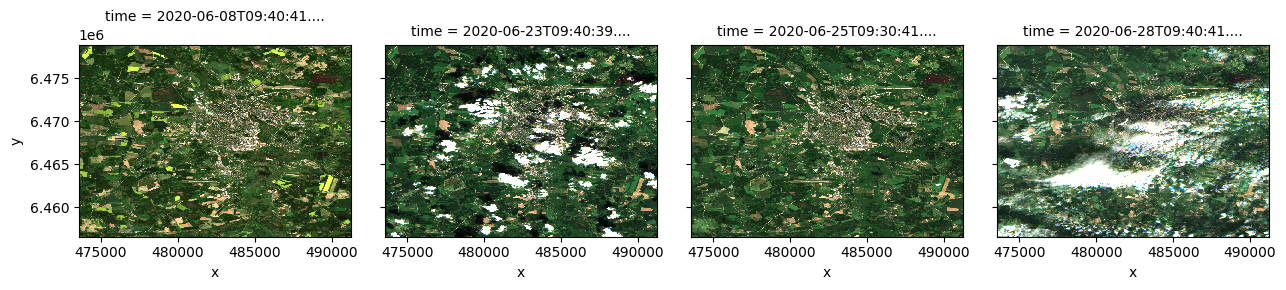

In [19]:
(s2_l2a/2000).clip(0,1).plot.imshow(col="time",col_wrap = 4)

## Part 2. Google Earth Engine (GEE)

[Google Earth Engine (GEE)](https://earthengine.google.com/) is a computing platform linked to a catalog for cloud-based geospatial processing.

<img src="https://developers.google.com/static/earth-engine/images/og_social_media.png" alt="gee" width="700"/>

While its catalog relies on STAC, it is just publicly available via its own API: `earthengine-api`

Note that you need a GEE account for using this!

In [20]:
import ee

ee.Authenticate()
ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com',project="ee-dmlmont")

Creating an ESDC from GEE is somehow easier than using pure STAC thanks to `xee` (see the [github repo here](https://github.com/google/Xee)).

First, let's create the bounding box EE polygon for Tartu:

In [21]:
tartu = ee.Geometry.Polygon(bbox["coordinates"])

Now, let's filter the Sentinel-2 L2A image collection:

In [22]:
s2_l2a_gee_ic = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterDate(start_date, end_date)
    .filterBounds(tartu)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
    .select(["B4","B3","B2"])
)

Now, here comes the magic: `xee` creates a GEE data store for `xarray`, so we can laod it directly!

In [23]:
import xarray as xr

Let's do it!

In [24]:
s2_l2a_gee = xr.open_dataset(
    s2_l2a_gee_ic,
    engine='ee',
    geometry=tartu,
    scale=30,
    crs="EPSG:32635",
    chunks=dict(),
)

Let's rearrange the ESDC so we can visualize it:

In [25]:
s2_l2a_gee = s2_l2a_gee.to_dataarray("band").transpose("time","band","Y","X")
s2_l2a_gee

<xarray.DataArray (time: 4, band: 3, Y: 740, X: 589)> Size: 21MB
dask.array<transpose, shape=(4, 3, 740, 589), dtype=float32, chunksize=(4, 1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 32B 2020-06-08T09:44:24.873000 ... 2020-06...
  * X        (X) float64 5kB 4.736e+05 4.736e+05 ... 4.912e+05 4.912e+05
  * Y        (Y) float64 6kB 6.457e+06 6.457e+06 ... 6.479e+06 6.479e+06
  * band     (band) object 24B 'B4' 'B3' 'B2'
Attributes: (12/18)
    date_range:             [1490659200000, 1647907200000]
    description:            <p>Sentinel-2 is a wide-swath, high-resolution, m...
    keywords:               ['copernicus', 'esa', 'eu', 'msi', 'reflectance',...
    period:                 0
    product_tags:           ['msi', 'sr', 'reflectance']
    provider:               European Union/ESA/Copernicus
    ...                     ...
    type_name:              ImageCollection
    visualization_0_bands:  B4,B3,B2
    visualization_0_max:    3000.0
    visualization_0_min:    0.0
    visualization_0_name:   RGB
    crs:                    EPSG:32635

Let's load it in memory:

In [26]:
with ProgressBar():
    s2_l2a_gee = s2_l2a_gee.compute()

[########################################] | 100% Completed | 3.52 ss


And now we can visualize it!

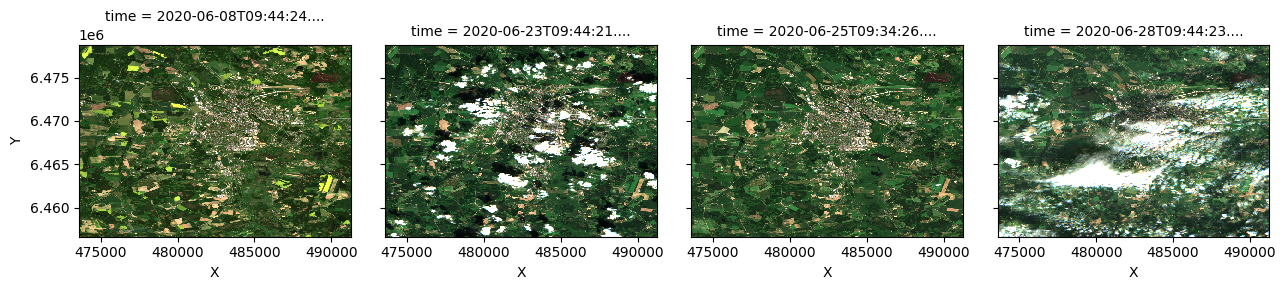

In [27]:
(s2_l2a_gee/2000).clip(0,1).plot.imshow(col="time",col_wrap = 4)

## Appending another collection to our ESDC

Now, let's append a unidimensional product: Air temperature from ERA5-Land.

In [28]:
air_temperature = (ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY")
    .filterDate(start_date, end_date)
    .filterBounds(tartu)
    .select(["temperature_2m"])
)

Let's open it with `xarray`:

In [29]:
air_temperature_gee = xr.open_dataset(
    air_temperature,
    engine='ee',
    geometry=tartu,
    chunks=dict(),
)

Note that since the spatial resolution of ERA5 is 0.1 deg, so for Tartu this is actually just one pixel!

In [30]:
air_temperature_gee

<xarray.Dataset> Size: 9kB
Dimensions:         (time: 720, lon: 1, lat: 1)
Coordinates:
  * time            (time) datetime64[ns] 6kB 2020-06-01 ... 2020-06-30T23:00:00
  * lon             (lon) float64 8B 27.05
  * lat             (lat) float64 8B 58.75
Data variables:
    temperature_2m  (time, lon, lat) float32 3kB dask.array<chunksize=(48, 1, 1), meta=np.ndarray>
Attributes: (12/33)
    date_range:               [347155200000, 1640649600000]
    description:              <p>ERA5-Land is a reanalysis dataset providing ...
    keywords:                 ['cds', 'climate', 'copernicus', 'ecmwf', 'era5...
    period:                   0
    product_tags:             ['temperature', 'lakes', 'snow', 'soil_water', ...
    provider:                 Climate Data Store
    ...                       ...
    visualization_3_bands:    u_component_of_wind_10m
    visualization_3_max:      30.0
    visualization_3_min:      0.0
    visualization_3_name:     u-component of wind at 10m
    visualization_3_palette:  #FFFFFF,#FFFF71,#DEFF00,#9EFF00,#77B038,#007E55...
    crs:                      EPSG:4326

We can get rid of them and interpolate to the times of our Sentinel-2 ESDC so we can merge them:

In [31]:
with ProgressBar():
    air_temperature_gee = air_temperature_gee['temperature_2m'][:,0,0].interp(time = s2_l2a_gee.time).compute()

[########################################] | 100% Completed | 5.04 sms


Now it just has 4 time coordinates, the same coordinates as our S2 L2A cube!

In [32]:
air_temperature_gee

<xarray.DataArray 'temperature_2m' (time: 4)> Size: 32B
array([296.6689227 , 296.09814439, 298.66664856, 299.08959679])
Coordinates:
    lon      float64 8B 27.05
    lat      float64 8B 58.75
  * time     (time) datetime64[ns] 32B 2020-06-08T09:44:24.873000 ... 2020-06...
Attributes:
    id:             temperature_2m
    data_type:      {'type': 'PixelType', 'precision': 'double'}
    dimensions:     [3601, 1801]
    crs:            EPSG:4326
    crs_transform:  [0.1, 0, -180.05, 0, -0.1, 90.05]

We can reset the additional coordinates:

In [33]:
air_temperature_gee = air_temperature_gee.reset_coords(drop=True)

Now, let's prepare our ESDCs to be merged:

In [34]:
air_temperature_gee.name = "temperature_2m"
air_temperature_gee = air_temperature_gee.to_dataset()

s2_l2a_gee = s2_l2a_gee.to_dataset("band")

Now we can merge!

In [35]:
merged_esdc = air_temperature_gee.merge(s2_l2a_gee)
merged_esdc

<xarray.Dataset> Size: 21MB
Dimensions:         (time: 4, Y: 740, X: 589)
Coordinates:
  * time            (time) datetime64[ns] 32B 2020-06-08T09:44:24.873000 ... ...
  * X               (X) float64 5kB 4.736e+05 4.736e+05 ... 4.912e+05 4.912e+05
  * Y               (Y) float64 6kB 6.457e+06 6.457e+06 ... 6.479e+06 6.479e+06
Data variables:
    temperature_2m  (time) float64 32B 296.7 296.1 298.7 299.1
    B4              (time, Y, X) float32 7MB 1.176e+03 642.0 ... 367.0 349.0
    B3              (time, Y, X) float32 7MB 1.065e+03 743.0 ... 744.0 732.0
    B2              (time, Y, X) float32 7MB 672.0 382.0 337.0 ... 421.0 396.0

## Part 3. BONUS: Creating AI-focused ESDCs from STAC or GEE with `cubo`

`cubo` ([Montero et al., 2024](https://doi.org/10.48550/arXiv.2404.13105)) is a tool that automatically creates AI-focused ESDCs given a small set of parameters.

<img src="https://github.com/davemlz/cubo/raw/main/docs/_static/logo.png" alt="cubo" width="700"/>

An AI-focused ESDC is an ESDC where the spatial dimensions share the same length. Given this, an AI-focused ESDC can be defined using the following parameters:

<img src="https://github.com/davemlz/cubo/raw/main/docs/_static/cubo_desc.png" alt="cubo-parameters" width="1000"/>

Let's import `cubo`.

In [36]:
import cubo

Now, let's create an AI-focused cube for Tartu! Note it is a lazy array:

In [42]:
da = cubo.create(
    lat=58.37224, # Central latitude of the cube
    lon=26.72636, # Central longitude of the cube
    collection="sentinel-2-l2a", # Name of the STAC collection
    bands=["B04","B03","B02"], # Bands to retrieve
    start_date=start_date, # Start date of the cube
    end_date=end_date, # End date of the cube
    edge_size=512, # Edge size of the cube (px)
    resolution=30, # Pixel size of the cube (m)
    query={"eo:cloud_cover": {"lt": 20}}
)

/net/home/dmontero/.conda/envs/foss4g24_esdc/lib/python3.12/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


Let's load it in memory:

In [44]:
with ProgressBar():
    da = da.compute()

[########################################] | 100% Completed | 1.01 sms


Let's visualize it!

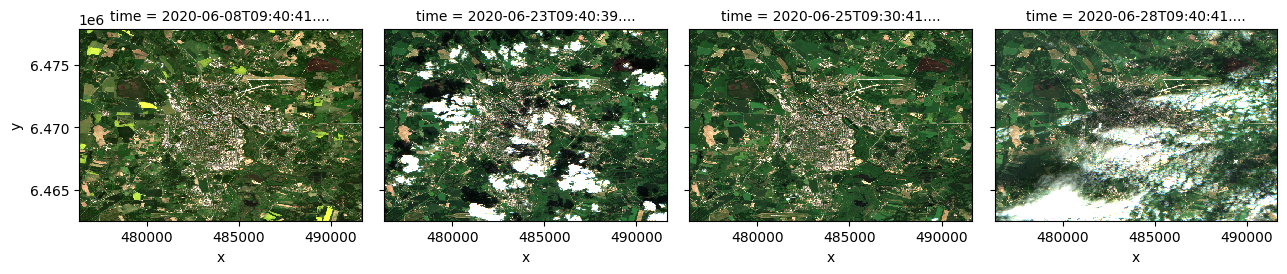

In [45]:
(da/2000).clip(0,1).plot.imshow(col="time",col_wrap = 4)

We can also use GEE:

In [52]:
da = cubo.create(
    lat=58.37224, # Central latitude of the cube
    lon=26.72636, # Central longitude of the cube
    collection="COPERNICUS/S2_SR_HARMONIZED", # Image Collection name
    bands=["B4","B3","B2"], # Bands to retrieve
    start_date=start_date, # Start date of the cube
    end_date=end_date, # End date of the cube
    edge_size=512, # Edge size of the cube (px)
    resolution=30, # Pixel size of the cube (m)
    gee=True
)

Let's put it in memory:

In [49]:
with ProgressBar():
    da = da.compute()

[########################################] | 100% Completed | 3.32 ss


There are more images because we didn't filter by cloud cover:

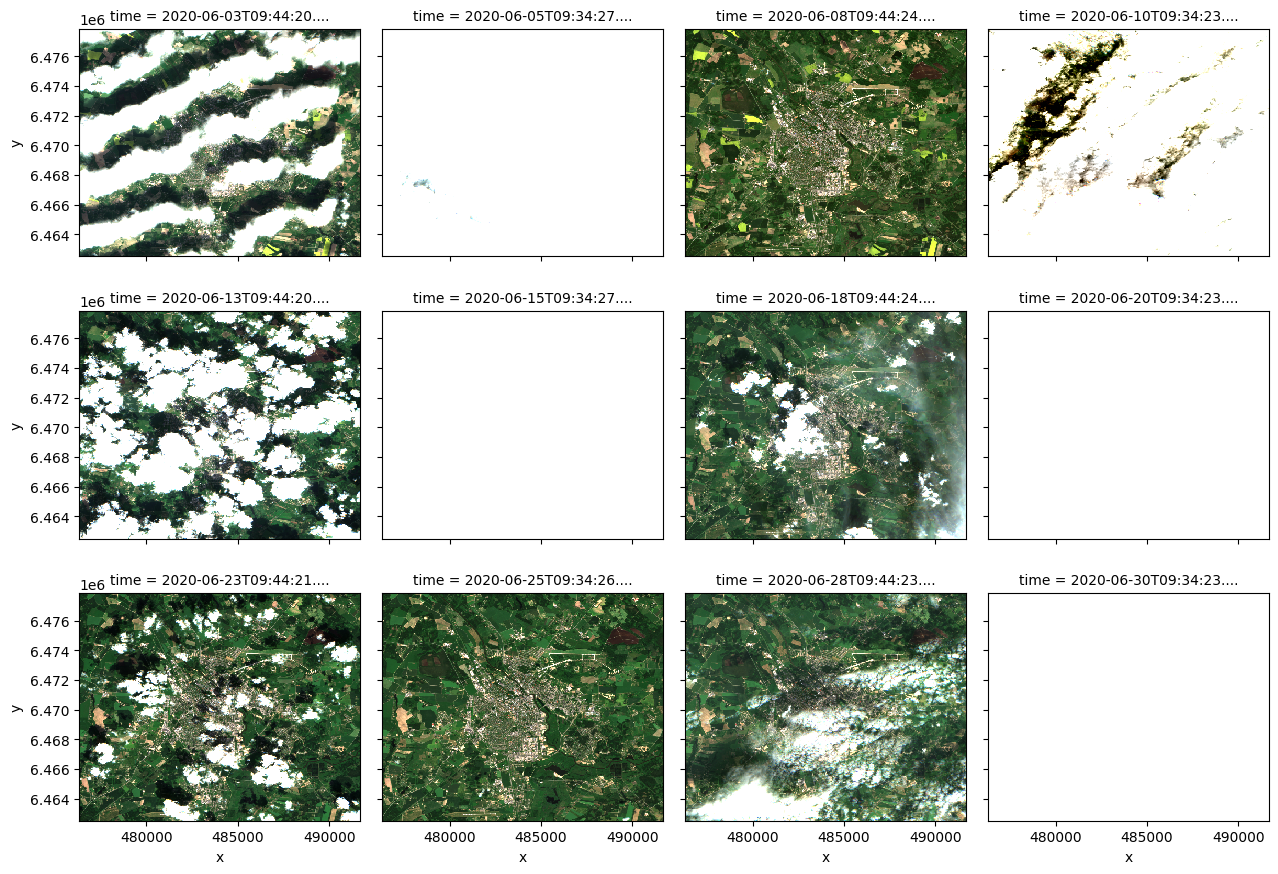

In [50]:
(da/2000).clip(0,1).plot.imshow(col="time",col_wrap = 4)

But we can solve that by filtering the image collection before hand!

In [53]:
S2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED').filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20))

Now we can pass the filtered image collection:

In [54]:
da = cubo.create(
    lat=58.37224, # Central latitude of the cube
    lon=26.72636, # Central longitude of the cube
    collection=S2, # Image Collection
    bands=["B4","B3","B2"], # Bands to retrieve
    start_date=start_date, # Start date of the cube
    end_date=end_date, # End date of the cube
    edge_size=512, # Edge size of the cube (px)
    resolution=30, # Pixel size of the cube (m)
    gee=True
)

Let's load it in memory:

In [56]:
with ProgressBar():
    da = da.compute()

[########################################] | 100% Completed | 2.26 ss


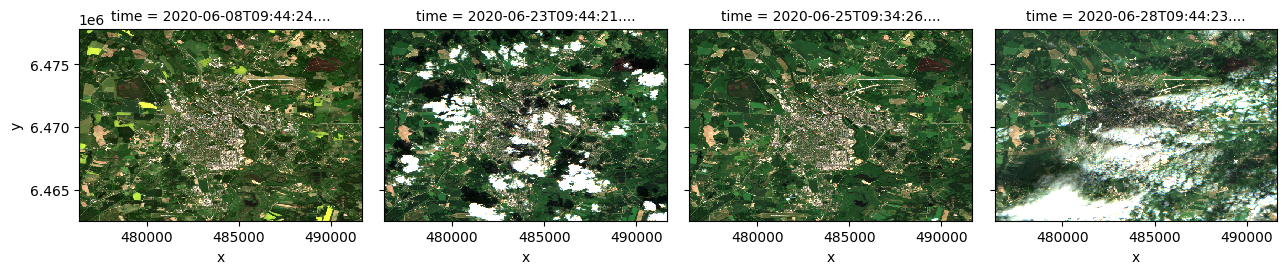

In [57]:
(da/2000).clip(0,1).plot.imshow(col="time",col_wrap = 4)